# 새 섹션

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Bidirectional
import keras
import datetime


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/containertotal.csv')
data.head()

,useYm,total,eContnTeuTotal
0,201101,1114700,NaN
1,201102,955254,NaN
2,201103,1279939,NaN
3,201104,1237088,NaN
4,201105,1273897,NaN


In [ ]:
containers=data['total'].values

In [ ]:
seq_len = 6
sequence_length = seq_len + 1

result = []
for index in range(len(containers) - sequence_length):
    result.append(containers[index: index + sequence_length])

In [ ]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((102, 6, 1), (11, 6, 1))

In [ ]:
# model = Sequential()

# model.add(LSTM(50, return_sequences=True, input_shape=(6, 1)))

# model.add(LSTM(64, return_sequences=True))

# model.add(LSTM(64, return_sequences=False))

# model.add(Dense(1, activation='linear'))

# model.compile(loss='mse', optimizer='Adam')

# model.summary()
model = Sequential()

model.add(Bidirectional(LSTM(40, return_sequences = True), input_shape = (6,1)))
model.add(Bidirectional(LSTM(80, return_sequences = True,dropout=0.3)))
model.add(Bidirectional(LSTM(80, return_sequences = False,dropout=0.3)))
model.add(Dense(1,activation='ELU'))

model.compile(loss = 'MSE', optimizer='Adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_115 (Bidirecti (None, 6, 80)             13440     
_________________________________________________________________
bidirectional_116 (Bidirecti (None, 6, 160)            103040    
_________________________________________________________________
bidirectional_117 (Bidirecti (None, 160)               154240    
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 161       
Total params: 270,881
Trainable params: 270,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=6,
    epochs=50,
    callbacks=[
        TensorBoard(log_dir='logs/%s' % (start_time)),
        ModelCheckpoint('./models/%s_eth.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
])

Epoch 1/50
17/17 [==============================] - 11s 210ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 0.0055 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.00552, saving model to ./models/2021_10_13_09_55_43_eth.h5
Epoch 2/50
17/17 [==============================] - 0s 20ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0053 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.00552 to 0.00534, saving model to ./models/2021_10_13_09_55_43_eth.h5
Epoch 3/50
17/17 [==============================] - 0s 20ms/step - loss: 0.0029 - accuracy: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved from 0.00534 to 0.00436, saving model to ./models/2021_10_13_09_55_43_eth.h5
Epoch 4/50
17/17 [==============================] - 0s 19ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0045 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.00436
Epoch 5/50
17/17 [=========

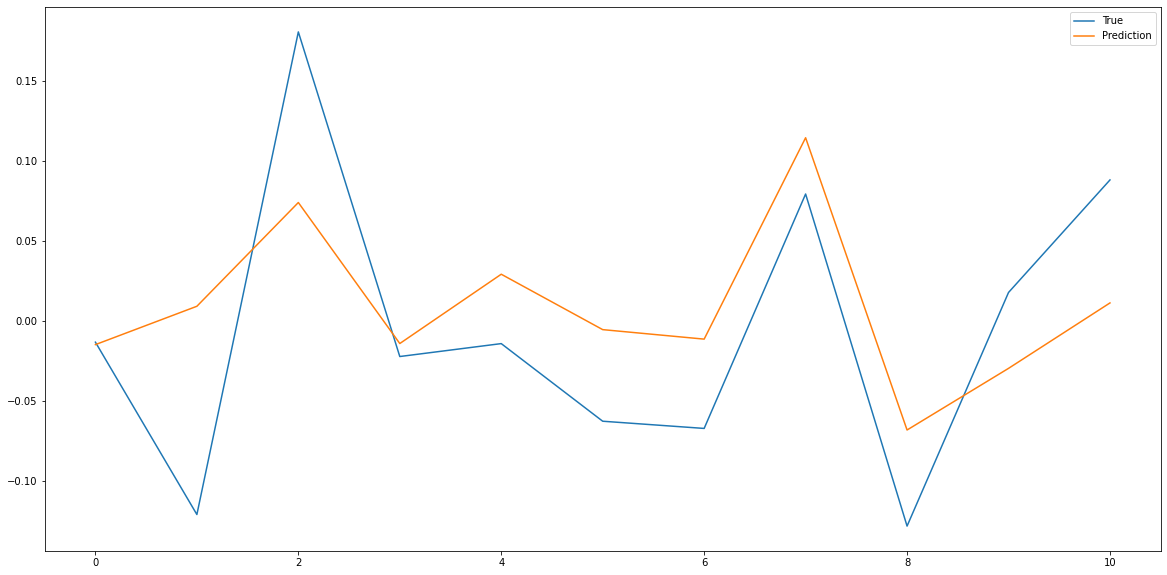

In [ ]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()